# Homework 3

In [2]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3925    0  3925    0     0  14377      0 --:--:-- --:--:-- --:--:-- 14377
100  503k  100  503k    0     0   697k      0 --:--:-- --:--:-- --:--:--  697k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3933    0  3933    0     0  17636      0 --:--:-- --:--:-- --:--:-- 17558
100  406k  100  406k    0     0   710k      0 --:--:-- --:--:-- --:--:--  710k


In [3]:
! pip install yfinance

     |████████████████████████████████| 63 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 10.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [30]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import yfinance as yf
import talib as ta
from talib import MA_Type  
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import TimeSeriesSplit

## Data and Preprocessing

### Using the yfinance library download daily Microsoft stock data with maximum history.

In [5]:
msft = yf.Ticker('MSFT')
df = msft.history('max')

In [6]:
df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-04-27,282.100006,290.970001,279.160004,283.220001,63477700,0.0,0.0
2022-04-28,285.190002,290.980011,281.459991,289.630005,33646600,0.0,0.0
2022-04-29,288.609985,289.880005,276.500000,277.519989,37025000,0.0,0.0
2022-05-02,277.709991,284.940002,276.220001,284.470001,35151100,0.0,0.0
2022-05-03,283.959991,284.130005,280.149994,281.779999,25978600,0.0,0.0
2022-05-04,282.589996,290.880005,276.730011,289.980011,33599300,0.0,0.0
2022-05-05,285.540009,286.350006,274.339996,277.350006,43260400,0.0,0.0
2022-05-06,274.809998,279.250000,271.269989,274.730011,37748300,0.0,0.0
2022-05-09,270.059998,272.359985,263.320007,264.579987,47726000,0.0,0.0


### Compute the following indicators using the pandas and ta-lib libraries

- Lagged High price
- Lagged Close price
- Lagged Low price
- Bollinger bands using lagged close price with timeperiod=20
- RSI using lagged close price with timeperiod=14
- MACD using lagged close price with fastperiod=12, slowperiod=26, signalperiod=9
- Momentum using lagged close price with timeperiod=12
- OBV with lagged close price and lagged volume
- ATR with lagged high, low, and close price
- Continuously compounded returns of the Open price
- CCI using lagged high, low, and close price.

In [7]:
df['High Shifted'] = df['High'].shift(1)
df['Low Shifted'] = df['Low'].shift(1)
df['Close Shifted'] = df['Close'].shift(1)
df['Upper BBand'], df['Middle BBand'], df['Lower BBand'] = ta.BBANDS(df['Close Shifted'],timeperiod=20)
df['RSI'] = ta.RSI(np.array(df['Close Shifted']), timeperiod=14)
df['Macd'], df['Macd Signal'], df['Macd Hist'] = ta.MACD(df['Close Shifted'], fastperiod=12, slowperiod=26, signalperiod=9)
df['OBV'] = ta.OBV(df['Close Shifted'],df['Volume'].shift(1))
df['ATR'] = ta.ATR(df['High'].shift(1), df['Low'].shift(1), df['Close'].shift(1))
df['Returns'] = np.log(df['Open'] / df['Open'].shift(1))
df['CCI'] = ta.CCI(df['High Shifted'], df['Low Shifted'], df['Close Shifted'])

df.dropna(inplace=True)

### You want to long the stock if the return is greater or equal to 1 percent, short the stock when the stock return is less than or equal to -1 percent, and do nothing if the return is between -1 and 1 (exclusive). Create the label where = 1 when R >= 0.01, =0 when -0.01 <= R <= 0.01, = -1 when R >= -0.01. 

In [8]:
def assign_label(v):
    if v <= -0.01:
        return -1
    elif v >= 0.01:
        return 1
    else:
        return 0

df['Label'] = df['Returns'].map(assign_label)

### Create the feature space X and label vector y. Your feature space should exclude the following variables: ’Label’,’Returns’,’Open’,’Close’,’Volume’,’High’,’Low’,’Dividends’, and ’Stock Splits’

In [9]:
X = df.drop(['Label', 'Returns', 'Open', 'Close', 'Volume', 'High', 'Low', 'Dividends', 'Stock Splits'], 1)
Y = df['Label']

### Create the train and test subsets. The training set will inlclude all data points except the last 30 days of the sample. The test sample will include the last 30 days of the sample.
You will need to fit a MinMaxScaler from the sklearn library to your train and test feature space separately. Therefore, you need to call the MinMaxScaler for both your training set and your test set.For the traning set the MinMaxScaler will use only the information contained in the training set (hint:use fit transform). For the test set the MinMaxScaler will transform the test set using information in the training set hint: use transform.


In [10]:
from sklearn import preprocessing
minmax = preprocessing.MinMaxScaler()

X_train = minmax.fit_transform(X.iloc[:-30, :])
X_test = pd.DataFrame(minmax.transform(X)).iloc[-30:, :]
y_train = Y.iloc[:-30]
y_test = Y.iloc[-30:]

## Discriminative Learning

### Use Logistic Regression with solver=liblinear’ to classify the label. 
Tune hyper-parameters ’penalty’ and ’C’ using GridSearchCV implementation and Time Series Split with n split=5, test size=1, gap=0. The grid search should search over: penalty: ’l1’,’l2’ and C:[0.1, 0.5, 1, 2, 3, 4, 5, 10]
Report the selected parameters, and accuracy on the training and test data.

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import TimeSeriesSplit

parameters = {'penalty': ['l1','l2'], 
              'C':[0.1, 0.5, 1, 2, 3, 4, 5, 10]} 

logreg = LogisticRegression(solver='liblinear')
lr_search = GridSearchCV(logreg, parameters, cv=TimeSeriesSplit(5, test_size=1, gap=0)) # takes 10 mins
lr_search.fit(X_train, y_train)
y_pred = lr_search.predict(X_test)

accuracy = accuracy_score(y_pred, y_test)
train_acc = accuracy_score(lr_search.predict(X_train), y_train)
print ('Selected Parameters: ', lr_search.best_params_)
print ('Training Accuracy = ' + str(train_acc))
print ('Test Accuracy = ' + str(accuracy))

# if don't want take 10 mins
# logreg = LogisticRegression(solver='liblinear', C=0.1, penalty='l2')
# logreg.fit(X_train, y_train)
# y_pred = logreg.predict(X_test)

# accuracy = accuracy_score(y_pred, y_test)
# train_acc = accuracy_score(logreg.predict(X_train), y_train)
# print ('Training Accuracy = ' + str(train_acc))
# print ('Test Accuracy = ' + str(accuracy))

y_pred_LR = y_pred

Selected Parameters:  {'C': 0.1, 'penalty': 'l2'}
Training Accuracy = 0.4954148712849409
Test Accuracy = 0.4


## Support Vector Machine

### Use Support Vector Machine to classify label. 
Tune hyper-parameters ‘C’ and ‘kernel’ using RandomizedSearchCV implementation and Time Series Split with n split=5, test size=1, gap=0.The randomized search should search over: ’C’:[0.3,0.5,1,5,10,20,30,50,100] and ’kernel’:[’linear’,’rbf’]. You will use the scoring method ‘f1 macro’ in the cross-validation.
Report the selected parameters. Report the accuracy, precision, and recall on the test data.


In [ ]:
SVC = SVC(kernel='rbf')
param_grid={'C':[0.3,0.5,1,5,10,20,30,50,100],
            'kernel':['linear', 'rbf']}
SVC_search = RandomizedSearchCV(SVC, param_distributions=param_grid, cv=TimeSeriesSplit(5, test_size=1, gap=0)) # 4 min to run
SVC_search.fit(X_train, y_train)
y_pred = SVC_search.predict(X_test)

y_pred_SVC = y_pred

In [19]:
from sklearn.metrics import f1_score
from sklearn import metrics

Accuracy = metrics.accuracy_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred, average='macro')
Precision = metrics.precision_score(y_test, y_pred, average='macro')
Recall = metrics.recall_score(y_test, y_pred, average='macro')

print ('Selected Parameters: ', SVC_search.best_params_)
print ('Test Accuracy: ' + str(Accuracy))
print ('f1 score: ', f_score)
print ('Precision: ', Precision)
print ('Recall: ', Recall)

Selected Parameters:  {'kernel': 'linear', 'C': 20}
Test Accuracy: 0.5
f1 score:  0.5084422657952069
Precision:  0.6385964912280702
Recall:  0.5227272727272727


### Show a graph that compares the cumulative sum returns of the logistics and SVM strategy returns to the market buy and hold returns. Which strategy is best? Is there a period one strategy is better than the other?

In [14]:
df2 = df.copy()

In [15]:
df2['SVM Signal'] = 0
df2['SVM Returns'] = 0

df2['LR Singal'] = 0
df2['LR Returns'] = 0
 
df2['Total Strat Returns SVM'] = 0
df2['Total Strat Returns LR'] = 0
df2['Market Returns'] = 0    

In [16]:
Signal_Column_SVM = df2.columns.get_loc('SVM Signal')
Strat_Column_SVM = df2.columns.get_loc('SVM Returns')

Signal_Column_LR = df2.columns.get_loc('LR Singal')
Strat_Column_LR = df2.columns.get_loc('LR Returns')

SVC_Return_Column = df2.columns.get_loc('Total Strat Returns SVM')
LR_Return_Column = df2.columns.get_loc('Total Strat Returns LR')
Market_Column = df2.columns.get_loc('Market Returns')
     
df2.iloc[-30:, Signal_Column_SVM] = list(map(int, y_pred_SVC))
df2['SVM Returns'] = df2['SVM Signal'] * df2['Returns'].shift(-1)

df2.iloc[-30:, Signal_Column_LR] = list(map(int, y_pred_LR))
df2['LR Returns'] = df2['LR Singal'] * df2['Returns'].shift(-1)
    
df2.iloc[-30:, SVC_Return_Column] = np.nancumsum(df2['SVM Returns'][-30:])
df2.iloc[-30:, LR_Return_Column] = np.nancumsum(df2['LR Returns'][-30:])
df2.iloc[-30:, Market_Column] = np.nancumsum(df2['Returns'][-30:])
    
# df2['SVM_Sharpe_Ratio'] = (df2['Total Strat Returns SVM'][-1] - df2['Market Returns'][-1]) / np.nanstd(df2['Total Strat Returns'][-30:])

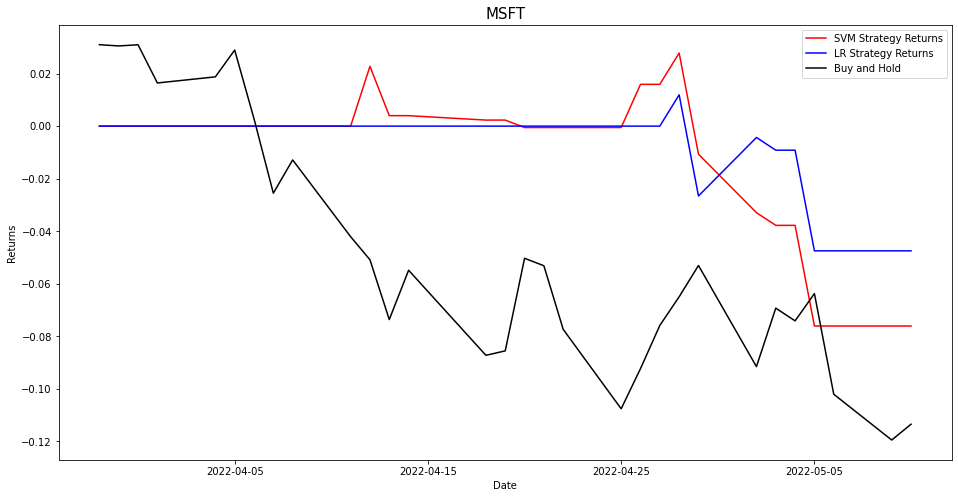

In [17]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df2[-30:].index.values, df2['Total Strat Returns SVM'][-30:].values, color='r', label="SVM Strategy Returns")
ax.plot(df2[-30:].index.values, df2['Total Strat Returns LR'][-30:].values, color='b', label="LR Strategy Returns")
ax.plot(df2[-30:].index.values, df2['Market Returns'][-30:].values, color='k', label="Buy and Hold")
    
ax.set(xlabel= "Date", ylabel="Returns")
plt.title('MSFT', fontsize=15)
ax.xaxis.set_major_locator(ticker.AutoLocator())
    
# plt.figtext(.95,0.78, s="Sharpe Ratio " + '5.27')
# plt.figtext(.95,0.75, s="Sum Total Strat Returns " + '0.49')
# plt.figtext(.95,0.72, s="Model Accuracy " + '0.6')
# plt.figtext(.95,0.69, s="Model Precision " + '0.72')
# plt.figtext(.95,0.66, s="Model Recall " + '0.47')
    
plt.legend(loc='best')
plt.show()

### Do you think these results are dependent on the cross-validation method and scoring? Do you think that if you change the scoring method you would get different results? Hint: think of the mathematical formulas used for scoring in the Randomized Search CV and Grid Search CV. For SVM we used f1 macro.

Changing the scoring method will change the results.

When we use F1-marco, we take the unweighted average f1 score for the dataset. But in the question of SVM, there are three classes and the validation dataset might have an uneven distribution. Therefore, the results may change.

### Bonus: Provide supporting empirical evidence to your answers in question 9. Hint: Run additional models with your suggested CV and hyper-parameter selection. You can show a graph comparing your new method’s performance relative to your answers in question 8.

In [38]:
SVC2 = SVC(kernel='rbf')
param_grid={'C':[0.3,0.5,1,5,10,20,30,50,100],
            'kernel':['linear', 'rbf']}
SVC_search = RandomizedSearchCV(SVC2, param_distributions=param_grid, cv=TimeSeriesSplit(5, test_size=1, gap=0), scoring='roc_auc') # 6 min to run
SVC_search.fit(X_train, y_train)
y_pred = SVC_search.predict(X_test)

y_pred_SVC = y_pred

In [39]:
Accuracy = metrics.accuracy_score(y_test, y_pred)
f_score = f1_score(y_test, y_pred, average='macro')
Precision = metrics.precision_score(y_test, y_pred, average='macro')
Recall = metrics.recall_score(y_test, y_pred, average='macro')

print ('Selected Parameters: ', SVC_search.best_params_)
print ('Test Accuracy: ' + str(Accuracy))
print ('f1 score: ', f_score)
print ('Precision: ', Precision)
print ('Recall: ', Recall)

Selected Parameters:  {'kernel': 'rbf', 'C': 0.5}
Test Accuracy: 0.26666666666666666
f1 score:  0.14035087719298248
Precision:  0.08888888888888889
Recall:  0.3333333333333333


In [40]:
df2['SVM2 Signal'] = 0
df2['SVM2 Returns'] = 0
df2['Total Strat Returns SVM2'] = 0
Signal_Column_SVM2 = df2.columns.get_loc('SVM2 Signal')
Strat_Column_SVM2 = df2.columns.get_loc('SVM2 Returns')

SVC_Return_Column2 = df2.columns.get_loc('Total Strat Returns SVM2')
     
df2.iloc[-30:, Signal_Column_SVM2] = list(map(int, y_pred_SVC))
df2['SVM2 Returns'] = df2['SVM2 Signal'] * df2['Returns'].shift(-1)
    
df2.iloc[-30:, SVC_Return_Column2] = np.nancumsum(df2['SVM2 Returns'][-30:])



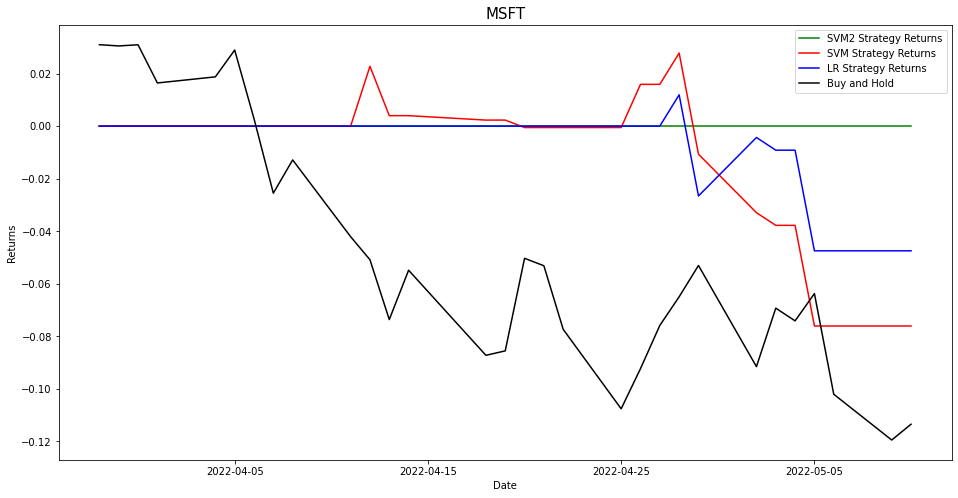

In [41]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(df2[-30:].index.values, df2['Total Strat Returns SVM2'][-30:].values, color='g', label="SVM2 Strategy Returns")
ax.plot(df2[-30:].index.values, df2['Total Strat Returns SVM'][-30:].values, color='r', label="SVM Strategy Returns")
ax.plot(df2[-30:].index.values, df2['Total Strat Returns LR'][-30:].values, color='b', label="LR Strategy Returns")
ax.plot(df2[-30:].index.values, df2['Market Returns'][-30:].values, color='k', label="Buy and Hold")
    
ax.set(xlabel= "Date", ylabel="Returns")
plt.title('MSFT', fontsize=15)
ax.xaxis.set_major_locator(ticker.AutoLocator())
 
plt.legend(loc='best')
plt.show()